### In this notebook, we will work through a couple of classification problems using PyTorch. The flow will be as follows:
1. We will start with the **make_moons** dataset from **sklearn** to practice binary classification.

2. As the first step, we’ll apply a linear regression model to this dataset to observe its performance.

3. Next, to understand the importance of non-linearity in model design, we will build a neural network with a ReLU activation in the hidden layers and a sigmoid activation in the output layer.

4. After gaining confidence with binary classification, we will shift our focus to a **spiral dataset** (see [reference link](https://cs231n.github.io/neural-networks-case-study/#data)), which is popular for multi-class classification practice.

5. Finally, we will explore different evaluation metrics to assess our model performance.

In [195]:
# Importing necessary packages and config for device agnostic code
import torch
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"


In [196]:
#Step 1 - Lets build the make_moons dataset
NUM_SAMPLES=1000
RANDOM_STATE=42

X,y = make_moons(NUM_SAMPLES,random_state=RANDOM_STATE,noise=0.05)

#Converting from numpy array to tensor so that it becomes easy for model training
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

#Checking the shape
X.shape,y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

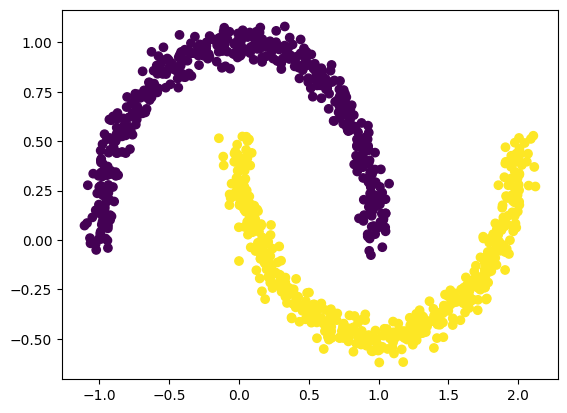

In [197]:
# Step 2 - Visualize the data

plt.scatter(X[:,0],X[:,1],c=y)


Shape of Training Data - X - torch.Size([800, 2]), Y - torch.Size([800]) 
Shape of Test Data - X - torch.Size([200, 2]), Y - torch.Size([200]) 


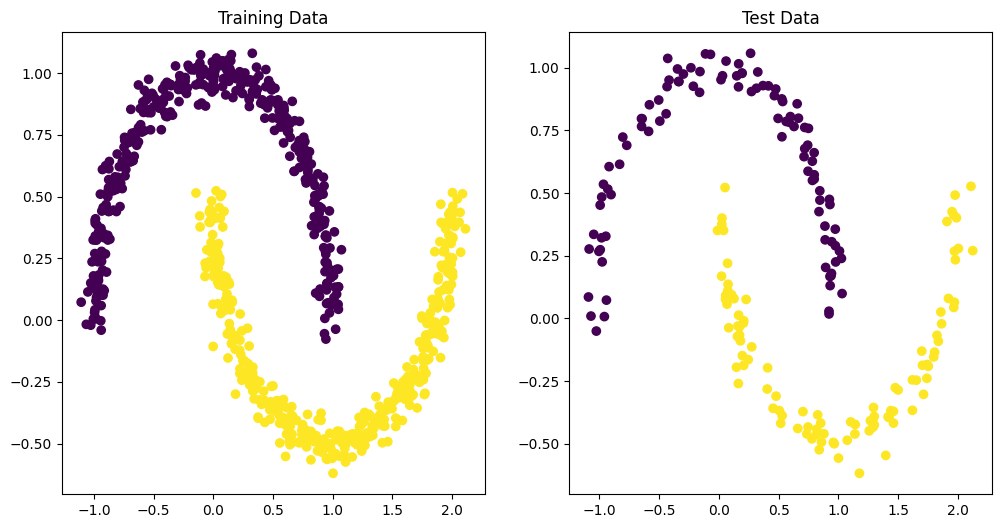

In [198]:
# Step 3 - Split the train and test data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE)
print(f"Shape of Training Data - X - {X_train.shape}, Y - {y_train.shape} ")
print(f"Shape of Test Data - X - {X_test.shape}, Y - {y_test.shape} ")
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Training Data")
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.subplot(1,2,2)
plt.title("Test Data")
plt.scatter(X_test[:,0],X_test[:,1],c=y_test)


In [199]:
# Step 4 - Building a linear model 
from torch import nn

class MoonModelV1 (nn.Module):
    def __init__(self,in_features,out_features,hidden_units=8):
        super().__init__()
        # Defining neural network with three layers (All linear)
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=out_features)

        )
    def forward(self,x):
        return self.linear_layer_stack(x)    
    
model_1 = MoonModelV1(in_features=2,out_features=1)
model_1.to(device)
model_1

MoonModelV1(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [200]:
#Before getting to the training, lets define some helper functions.

# Function to calcualte the accuracy of the model
import numpy as np
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


In [201]:
# Step 5 - Building a training and testing loop

# Setting random state for reproduciability
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

# Definif Loss Function and Optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr=0.1)

# Setting epoch.
epochs = 100
# Ensuring data and model are all available in same device.

X_train,X_test = X_train.to(device),X_test.to(device)
y_train,y_test = y_train.to(device),y_test.to(device)

# The Loop

for epoch in range(epochs):

    # Training
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss=loss_fn(y_logits,y_train)

    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    
    if epoch % 10 == 0:
        print(f"Epoch - {epoch} | Train -> Loss - {loss:.5f}, Accuracy - {acc:.2f}% | Test -> Loss - {test_loss:.5f}, Accuracy - {test_acc:.2f}%")

    

Epoch - 0 | Train -> Loss - 0.75641, Accuracy - 35.00% | Test -> Loss - 0.73435, Accuracy - 39.50%
Epoch - 10 | Train -> Loss - 0.65349, Accuracy - 74.75% | Test -> Loss - 0.64684, Accuracy - 79.50%
Epoch - 20 | Train -> Loss - 0.56467, Accuracy - 83.62% | Test -> Loss - 0.56444, Accuracy - 79.00%
Epoch - 30 | Train -> Loss - 0.46525, Accuracy - 81.25% | Test -> Loss - 0.47377, Accuracy - 78.00%
Epoch - 40 | Train -> Loss - 0.38977, Accuracy - 81.62% | Test -> Loss - 0.40674, Accuracy - 77.50%
Epoch - 50 | Train -> Loss - 0.34850, Accuracy - 82.12% | Test -> Loss - 0.36856, Accuracy - 78.50%
Epoch - 60 | Train -> Loss - 0.32551, Accuracy - 83.38% | Test -> Loss - 0.34504, Accuracy - 80.00%
Epoch - 70 | Train -> Loss - 0.31007, Accuracy - 83.62% | Test -> Loss - 0.32774, Accuracy - 82.00%
Epoch - 80 | Train -> Loss - 0.29802, Accuracy - 84.62% | Test -> Loss - 0.31347, Accuracy - 83.00%
Epoch - 90 | Train -> Loss - 0.28790, Accuracy - 85.00% | Test -> Loss - 0.30114, Accuracy - 84.50%


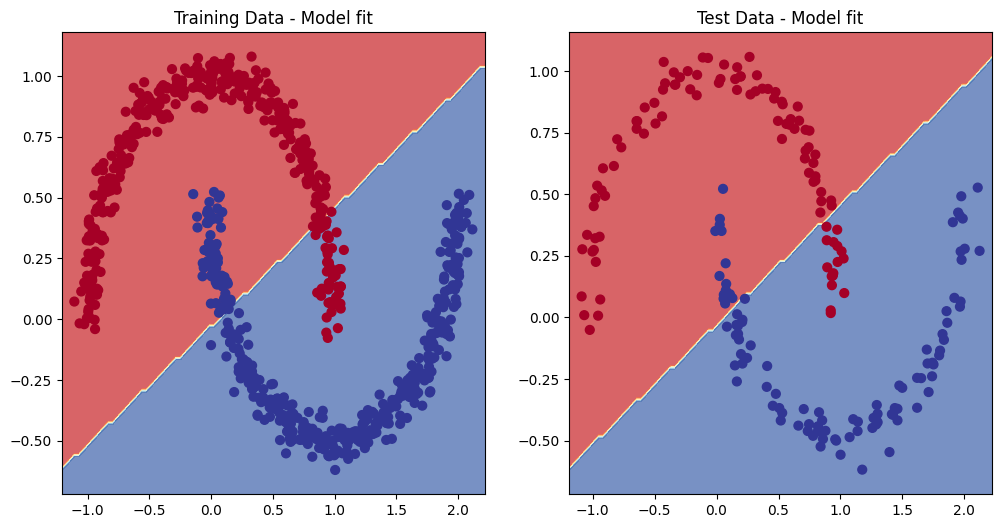

In [202]:
#Visualize - to understand the problem in using linear models for a classification problem.
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Training Data - Model fit")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test Data - Model fit")
plot_decision_boundary(model_1,X_test,y_test)

In [203]:
# Lets Define a new model by adding a non-linearity
from torch import nn

class MoonModelV2 (nn.Module):
    def __init__(self,in_features,out_features,hidden_units=8):
        super().__init__()
        # Defining neural network with three layers (All linear)
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),

            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=out_features)

        )
    def forward(self,x):
        return self.linear_layer_stack(x)    
    
model_2 = MoonModelV2(in_features=2,out_features=1)
model_2.to(device)
model_2


MoonModelV2(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [204]:
# Step 5 - Building a training and testing loop

# Setting random state for reproduciability
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

# Definif Loss Function and Optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(),lr=0.1)

# Setting epoch.
epochs = 1000
# Ensuring data and model are all available in same device.

X_train,X_test = X_train.to(device),X_test.to(device)
y_train,y_test = y_train.to(device),y_test.to(device)

# The Loop

for epoch in range(epochs):

    # Training
    model_2.train()

    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss=loss_fn(y_logits,y_train)

    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_2.eval()

    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    
    if epoch % 100 == 0:
        print(f"Epoch - {epoch} | Train -> Loss - {loss:.5f}, Accuracy - {acc:.2f}% | Test -> Loss - {test_loss:.5f}, Accuracy - {test_acc:.2f}%")

    

Epoch - 0 | Train -> Loss - 0.71199, Accuracy - 50.00% | Test -> Loss - 0.70546, Accuracy - 50.00%
Epoch - 100 | Train -> Loss - 0.36222, Accuracy - 84.88% | Test -> Loss - 0.37499, Accuracy - 83.50%
Epoch - 200 | Train -> Loss - 0.24144, Accuracy - 88.50% | Test -> Loss - 0.24049, Accuracy - 90.00%
Epoch - 300 | Train -> Loss - 0.22168, Accuracy - 89.50% | Test -> Loss - 0.21596, Accuracy - 90.50%
Epoch - 400 | Train -> Loss - 0.20242, Accuracy - 90.62% | Test -> Loss - 0.19498, Accuracy - 91.50%
Epoch - 500 | Train -> Loss - 0.17213, Accuracy - 92.38% | Test -> Loss - 0.16379, Accuracy - 93.50%
Epoch - 600 | Train -> Loss - 0.13007, Accuracy - 95.00% | Test -> Loss - 0.12163, Accuracy - 95.50%
Epoch - 700 | Train -> Loss - 0.08703, Accuracy - 97.62% | Test -> Loss - 0.07933, Accuracy - 98.50%
Epoch - 800 | Train -> Loss - 0.05595, Accuracy - 99.12% | Test -> Loss - 0.04967, Accuracy - 99.50%
Epoch - 900 | Train -> Loss - 0.03756, Accuracy - 99.62% | Test -> Loss - 0.03257, Accuracy -

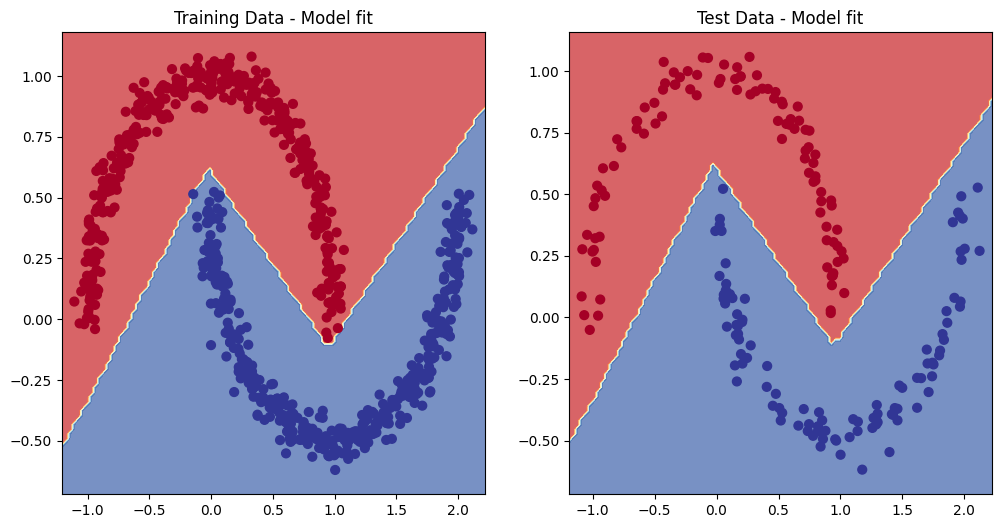

In [205]:
#Visualize - to understand the problem in using linear models for a classification problem.
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Training Data - Model fit")
plot_decision_boundary(model_2,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test Data - Model fit")
plot_decision_boundary(model_2,X_test,y_test)

## Multi-class classification 
Dataset from - https://cs231n.github.io/neural-networks-case-study/#data

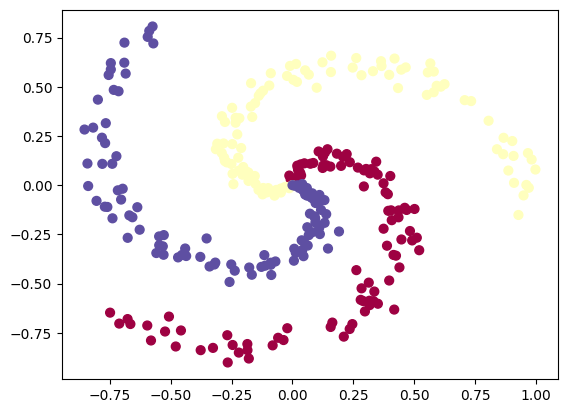

In [206]:
# Generating the data
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)
plt.show()

Shape of Training Data - X - torch.Size([240, 2]), Y - torch.Size([240]) 
Shape of Test Data - X - torch.Size([60, 2]), Y - torch.Size([60]) 
Unique output values - tensor([0, 1, 2])


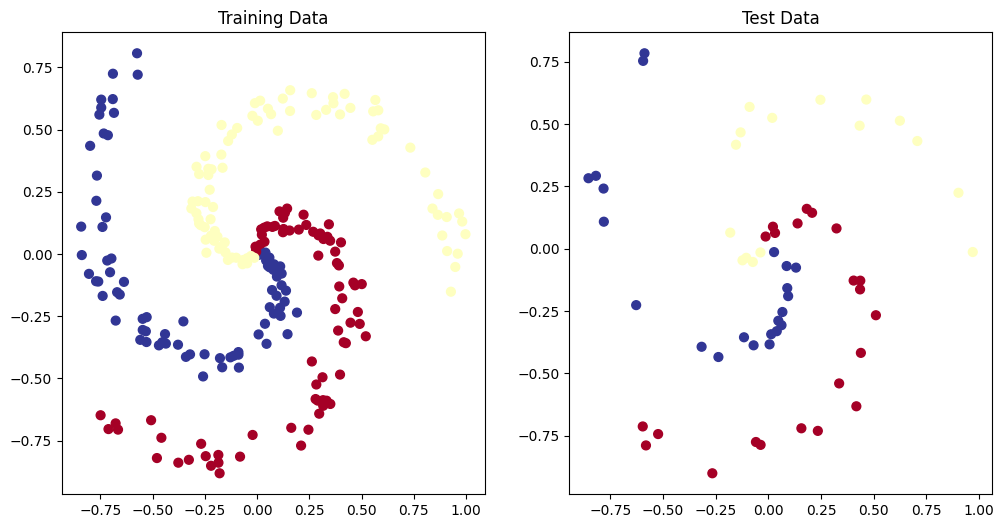

In [207]:
# Moving the data to tensor and creating test/train split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE)


print(f"Shape of Training Data - X - {X_train.shape}, Y - {y_train.shape} ")
print(f"Shape of Test Data - X - {X_test.shape}, Y - {y_test.shape} ")
print(f"Unique output values - {torch.unique(y)}")
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Training Data")
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,s=40,cmap=plt.cm.RdYlBu)
plt.subplot(1,2,2)
plt.title("Test Data")
plt.scatter(X_test[:,0],X_test[:,1],c=y_test,s=40,cmap=plt.cm.RdYlBu)


In [227]:
class SpiralModelV1 (nn.Module):
    def __init__(self,in_features,out_features,hidden_units=8):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=out_features)
        )
    def forward(self,x):
        return self.layer_stack(x)

model_3 = SpiralModelV1(in_features=2,out_features=3).to(device)
model_3

SpiralModelV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [234]:
# Building a training and testing loop

# Setting random state for reproduciability
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

# Definif Loss Function and Optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(),lr=0.03)

# Setting epoch.
epochs = 1000
# Ensuring data and model are all available in same device.

X_train,X_test = X_train.to(device),X_test.to(device)
y_train,y_test = y_train.to(device),y_test.to(device)

# The Loop

for epoch in range(epochs):

    # Training
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

    loss=loss_fn(y_logits,y_train)

    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()

    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    
    if epoch % 100 == 0:
        print(f"Epoch - {epoch} | Train -> Loss - {loss:.5f}, Accuracy - {acc:.2f}% | Test -> Loss - {test_loss:.5f}, Accuracy - {test_acc:.2f}%")


Epoch - 0 | Train -> Loss - 0.01534, Accuracy - 99.17% | Test -> Loss - 0.00017, Accuracy - 100.00%
Epoch - 100 | Train -> Loss - 0.01534, Accuracy - 99.17% | Test -> Loss - 0.00017, Accuracy - 100.00%
Epoch - 200 | Train -> Loss - 0.01533, Accuracy - 99.17% | Test -> Loss - 0.00017, Accuracy - 100.00%
Epoch - 300 | Train -> Loss - 0.01533, Accuracy - 99.17% | Test -> Loss - 0.00017, Accuracy - 100.00%
Epoch - 400 | Train -> Loss - 0.01533, Accuracy - 99.17% | Test -> Loss - 0.00017, Accuracy - 100.00%
Epoch - 500 | Train -> Loss - 0.01532, Accuracy - 99.17% | Test -> Loss - 0.00017, Accuracy - 100.00%
Epoch - 600 | Train -> Loss - 0.01532, Accuracy - 99.17% | Test -> Loss - 0.00017, Accuracy - 100.00%
Epoch - 700 | Train -> Loss - 0.01532, Accuracy - 99.17% | Test -> Loss - 0.00017, Accuracy - 100.00%
Epoch - 800 | Train -> Loss - 0.01532, Accuracy - 99.17% | Test -> Loss - 0.00017, Accuracy - 100.00%
Epoch - 900 | Train -> Loss - 0.01531, Accuracy - 99.17% | Test -> Loss - 0.00017, A

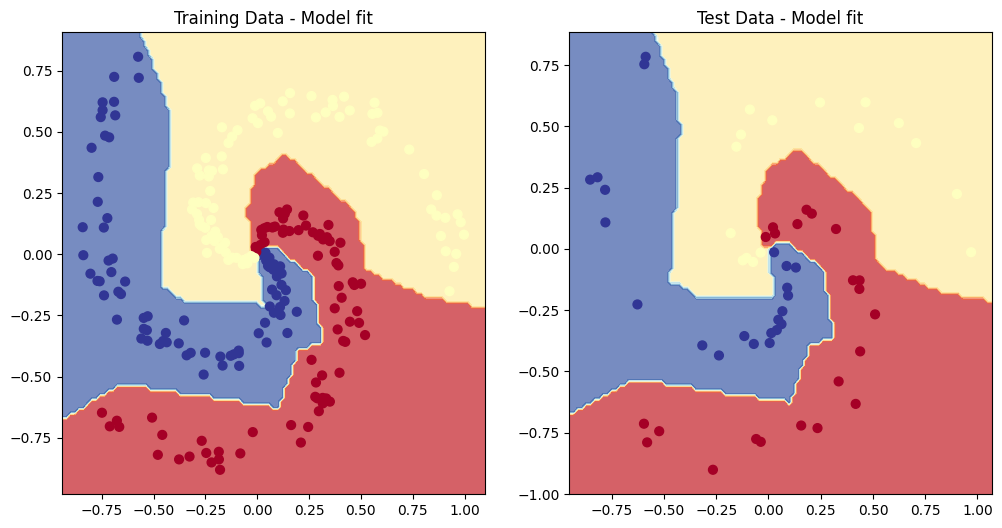

In [235]:
#Visualize - to understand the problem in using linear models for a classification problem.
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Training Data - Model fit")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test Data - Model fit")
plot_decision_boundary(model_3,X_test,y_test)

In [233]:
from torchmetrics.functional.classification import multiclass_accuracy
acc = multiclass_accuracy(test_pred, y_test, num_classes=3)
print(acc)


from sklearn.metrics import classification_report

report = classification_report(y_test, test_pred, target_names=['Class A', 'Class B', 'Class C'])

print(report)

tensor(1.)
              precision    recall  f1-score   support

     Class A       1.00      1.00      1.00        22
     Class B       1.00      1.00      1.00        16
     Class C       1.00      1.00      1.00        22

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

